In [1]:
import random
import math
import numpy as np

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, Aer
import qiskit.ignis.verification.randomized_benchmarking as rb

IBMQ.load_account()


Failed to import duecredit due to No module named 'duecredit'
/home/alan/aur/miniconda3/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "
/home/alan/aur/miniconda3/lib/python3.8/site-packages/qinfer/parallel.py:61: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_linear as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

In [3]:
def design_circuit(n_qubits, inv_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    for i, element in enumerate(inv_arr):
        if element == 1:
            circuit.x(i)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

In [4]:
def random_circuit(n_qubits):
    length_vector = [1]
    n_seeds = 1
    
    initial_list = list(range(0, n_qubits))    
    rb_pattern = []
    
    while len(initial_list) > 1:
        sample = random.sample(initial_list, 2)
        [initial_list.remove(i) for i in sample]
        rb_pattern.append(sample)
    
    if len(initial_list) == 1:
        rb_pattern.append([initial_list[0]])
    
    
    circuit, xdata = rb.randomized_benchmarking_seq(
        length_vector = [1],
        nseeds = 1,
        rb_pattern = rb_pattern
        )
    circuit = circuit[0][0]
    cregs = circuit.cregs
    
    circuit.remove_final_measurements(inplace=True)
    circuit.cregs = cregs
    
    for i in range(n_qubits):
        circuit.barrier(i)
        if (round(random.random())):
            circuit.x(i)
            circuit.barrier(i)
    
    return circuit

┌───┐┌───┐ ┌───┐   ░   ┌───┐ ┌─────┐┌───┐  ░  ┌───┐   ░             »
qr_0: ┤ H ├┤ S ├─┤ Y ├───░───┤ Y ├─┤ SDG ├┤ H ├──░──┤ X ├───░─────────────»
      └───┘├───┤┌┴───┴┐┌───┐ ├───┤ └──░──┘├───┤┌───┐├───┤ ┌───┐   ░  ┌───┐»
qr_1: ─────┤ X ├┤ SDG ├┤ H ├─┤ Z ├────░───┤ Z ├┤ H ├┤ S ├─┤ X ├───░──┤ X ├»
      ┌───┐└─┬─┘├─────┤├───┤ ├───┤    ░   ├───┤├───┤├───┤ └─┬─┘ ┌───┐└─░─┘»
qr_2: ┤ H ├──■──┤ SDG ├┤ H ├─┤ Z ├────░───┤ Z ├┤ H ├┤ S ├───■───┤ H ├──░──»
      ├───┤┌───┐└─────┘└───┘┌┴───┴┐ ┌───┐ ├───┤└─░─┘├───┤ ┌───┐ ├───┤  ░  »
qr_3: ┤ H ├┤ S ├─────────■──┤ SDG ├─┤ H ├─┤ Z ├──░──┤ Z ├─┤ H ├─┤ S ├──■──»
      ├───┤├───┤ ┌───┐ ┌─┴─┐└┬───┬┘ ├───┤ ├───┤  ░  ├───┤┌┴───┴┐├───┤┌─┴─┐»
qr_4: ┤ H ├┤ H ├─┤ S ├─┤ X ├─┤ H ├──┤ S ├─┤ Z ├──░──┤ Z ├┤ SDG ├┤ H ├┤ X ├»
      └───┘└───┘ └───┘ └───┘ └───┘  └───┘ └───┘  ░  └───┘└─────┘└───┘└───┘»
cr_0: ════════════════════════════════════════════════════════════════════»
                                                                          »
cr_1: ════════════════════════════════════════════════════════════════════»
                                                                          »
cr_2: ════════════════════════════════════════════════════════════════════»
                                                                          »
cr_3: ════════════════════════════════════════════════════════════════════»
                                                                          »
cr_4: ════════════════════════════════════════════════════════════════════»
                                                                          »
«                          
«qr_0: ────────────────────
«         ░                
«qr_1: ───░────────────────
«         ░                
«qr_2: ────────────────────
«      ┌─────┐┌───┐  ░     
«qr_3: ┤ SDG ├┤ H ├──░─────
«      ├─────┤├───┤┌───┐ ░ 
«qr_4: ┤ SDG ├┤ H ├┤ H ├─░─
«      └─────┘└───┘└───┘ ░ 
«cr_0: ════════════════════
«                          
«cr_1: ════════════════════
«                          
«cr_2: ════════════════════
«                          
«cr_3: ════════════════════
«                          
«cr_4: ════════════════════
«

In [10]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_16_melbourne')

n_qubits = 15

n_measurements = 200
n_experiments = 20
n_points = 2000

results = []

for i in range(n_experiments):    

    result_data = {}
    
    circuit = random_circuit(n_qubits)

    result_data['circuit'] = circuit
    result_data['risk'] = []
    result_data['mean'] = []
    result_data['len'] = len(circuit)
    
    dist = Distribution(n_points=n_points, n_qubits=n_qubits)

    for _ in range(n_measurements):
        
        inversion_arr = dist.next_experiment()       
        
        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)

        job = execute(tmp_circuit, backend, shots=1)
        
        result = job.result()
        outcome = list(map(int, list(list(result.get_counts(circuit).keys())[0])))     
        
        print("Measurements: {} Outcome: {}".format(inversion_arr, outcome))
        dist.measure(outcome, inversion_arr)
        
        result_data['risk'].append(dist.calc_bayes_risk())
        result_data['mean'].append(dist.calc_bayes_mean())

    
    result_data['distrubtion'] = dist
    results.append(result_data)


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 0, 1

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0

Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [0, 0, 0, 1

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 1, 0, 0

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] Outcome: [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Measurements: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
Measurements: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]
Measurements: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 1

Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1

Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 0, 1

Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1

Measurements: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [0, 1, 0, 1

Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1

Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 1, 1, 0

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Measurements: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 1

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 1

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 1, 1, 0

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] Outcome: [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]
Measurements: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] Outcome: [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 1, 0, 1

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] Outcome: [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] Outcome: [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] Outcome: [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] Outcome: [1, 1, 0, 1

KeyboardInterrupt: 

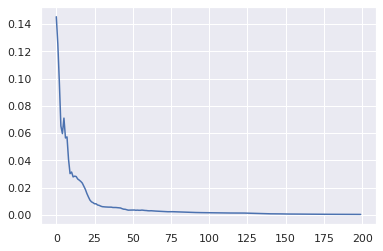

In [29]:
plt.plot(results[0]['risk'])

In [12]:
import pickle

In [58]:
f = open("15_q.pkl", "wb")
pickle.dump(results, f)
f.close()

In [20]:
for i in results:
    print(len(i['circuit']))

163
159
169
167


In [25]:
init_res = []
final_res = []
for res in results:
    
    init_circuit = copy.deepcopy(res['circuit'])
    init_circuit = design_circuit(n_qubits, [0] * n_qubits, circuit=init_circuit)
    
    inv_arr = res['mean'][-1]
    
    final_circuit = copy.deepcopy(i['circuit'])
    final_circuit = design_circuit(n_qubits, inv_arr, circuit=final_circuit)
    
    init_job = execute(init_circuit, backend, shots=4096)
    init_result = init_job.result()
    init_res.append(init_result.get_counts(circuit))
    
    final_job = execute(final_circuit, backend, shots=4096)
    final_result = final_job.result()
    final_res.append(final_result.get_counts(circuit))
    

In [33]:
def bootstrap(result, samples=900, repeats=1000):
    sampler = []
    for i in result:
        for _ in range(result[i]):
            sampler.append(int(i))
            
    target = int(max(result.keys(), key=lambda key: result[key]))
    
    probs = []
    
    for _ in range(repeats):
        tally = 0
        for i in range(samples):
            sample = sampler[random.randint(0, len(sampler) - 1)]
            
            if sample == target:
                tally += 1
        
        probs.append(tally / samples)
    return probs

In [42]:
results[0]['circuit'].draw()

┌───┐                                 ░         »
 qr_0: ────────■──────────┤ X ├─────────────────────────────────░─────────»
       ┌───┐   │    ┌───┐ └─┬─┘ ┌───┐         ┌───┐             ░  ┌─────┐»
 qr_1: ┤ H ├───┼────┤ H ├───┼───┤ S ├─────────┤ X ├────────■───────┤ SDG ├»
       └───┘ ┌─┴─┐  └───┘   │  ┌┴───┴┐ ┌───┐  └─┬─┘ ┌───┐  │    ░  └┬───┬┘»
 qr_2: ──────┤ X ├──────────■──┤ SDG ├─┤ H ├────┼───┤ Y ├──┼────░───┤ Y ├─»
             ├───┤  ┌───┐ ┌───┐└─────┘ └───┘    │   └───┘  │  ┌───┐ └───┘ »
 qr_3: ──────┤ H ├──┤ H ├─┤ S ├─────────────────┼─────■────┼──┤ X ├───■───»
             ├───┤ ┌┴───┴┐├───┤                 │     │  ┌─┴─┐└─┬─┘   │   »
 qr_4: ──────┤ H ├─┤ SDG ├┤ H ├─────────────────■─────┼──┤ X ├──┼─────┼───»
             ├───┤ └┬───┬┘└───┘       ┌─────┐ ┌───┐   │  ├───┤  │     │   »
 qr_5: ──────┤ H ├──┤ S ├─────────■───┤ SDG ├─┤ H ├───┼──┤ X ├──┼─────┼───»
             ├───┤  ├───┤ ┌───┐   │   └┬───┬┘ └─░─┘   │  ├───┤  │     │   »
 qr_6: ──────┤ H ├──┤ H ├─┤ S ├───┼────┤ Y ├────░─────┼──┤ Y ├──┼─────┼───»
             ├───┤  └───┘ └───┘ ┌─┴─┐ ┌┴───┴┐ ┌───┐   │  ├───┤  │     │   »
 qr_7: ──────┤ H ├──────────────┤ X ├─┤ SDG ├─┤ H ├───┼──┤ Z ├──┼─────┼───»
             ├───┤  ┌───┐       └───┘ └┬───┬┘┌┴───┴┐  │  ├───┤  │     │   »
 qr_8: ──────┤ H ├──┤ S ├──────────────┤ X ├─┤ SDG ├──┼──┤ H ├──┼─────┼───»
             └───┘  └───┘              └─┬─┘ └─────┘┌─┴─┐└───┘  │   ┌─┴─┐ »
 qr_9: ──────────────────────────────────┼──────────┤ X ├───────■───┤ X ├─»
             ┌───┐  ┌───┐ ┌───┐ ┌───┐    │          └───┘┌───┐  ░   ├───┤ »
qr_10: ──────┤ H ├──┤ H ├─┤ S ├─┤ X ├────┼────────────■──┤ Y ├──░───┤ Y ├─»
       ┌───┐ └───┘  └───┘ └───┘ └─┬─┘    │      ░     │  └───┘  ░   ├───┤ »
qr_11: ┤ X ├──────────────────────┼──────┼──────░─────┼─────────────┤ X ├─»
       └─┬─┘ ┌───┐  ┌───┐ ┌───┐   │      │      ░   ┌─┴─┐┌───┐  ░   └─┬─┘ »
qr_12: ──┼───┤ H ├──┤ H ├─┤ S ├───■──────┼──────────┤ X ├┤ Z ├──░─────┼───»
         │   ├───┤  ├───┤ ├───┤          │          ├───┤├───┤┌───┐   │   »
qr_13: ──┼───┤ H ├──┤ H ├─┤ S ├──────────■──────────┤ H ├┤ S ├┤ Z ├───┼───»
         │  ┌┴───┴┐ ├───┤ └───┘                 ░   ├───┤├───┤└───┘   │   »
qr_14: ──■──┤ SDG ├─┤ H ├───────────────────────░───┤ H ├┤ S ├────────■───»
            └─────┘ └───┘                       ░   └───┘└───┘            »
 cr_0: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_1: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_2: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_3: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_4: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_5: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_6: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_7: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_8: ═══════════════════════════════════════════════════════════════════»
                                                                          »
 cr_9: ═══════════════════════════════════════════════════════════════════»
                                                                          »
cr_10: ═══════════════════════════════════════════════════════════════════»
                                                                          

In [56]:
samples = 64
n_repeats = 64

x_coords = np.array([[len(res['circuit'])] * n_repeats for res in results]).flatten()
y_coords_init = 1 - np.array([bootstrap(res, samples=samples, repeats=n_repeats) for res in init_res]).flatten()


y_coords_final = 1 - np.array([bootstrap(res, samples=samples, repeats=n_repeats) for res in final_res]).flatten()

Text(0.5, 0, 'Circuit Depth')

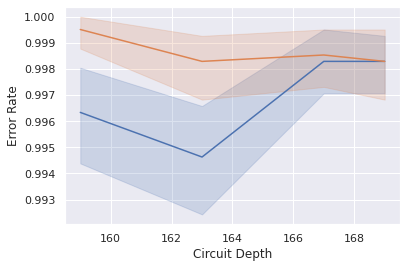

In [57]:
sbs.lineplot(x_coords, y_coords_init)
sbs.lineplot(x_coords, y_coords_final)

plt.ylabel('Error Rate')
plt.xlabel('Circuit Depth')